<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import holidays
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [177]:
!pip install holidays --upgrade

In [178]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv


File ‘DAYTON_hourly.csv’ already there; not retrieving.



In [179]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

#data.resample('3H').sum()
#data = data.resample('6H').sum()
data = data.resample('12H').sum()
#data.resample('1D').sum()
#data.resample('1W').sum()
#data.resample('1Y').sum()
#data.groupby([data.index.year == 2015,data.index.month <3 ])['DAYTON_MW'].sum()

In [180]:
data.shape

(10109, 1)

In [181]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-08-01 00:00:00,22046.0
2018-08-01 12:00:00,27401.0
2018-08-02 00:00:00,22058.0
2018-08-02 12:00:00,29979.0
2018-08-03 00:00:00,2042.0


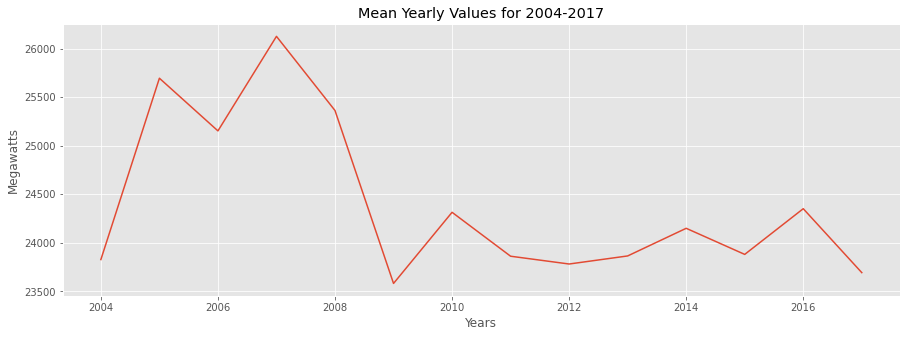

In [182]:
# YEARLY CONSUMPTIONS

mean_yearly_consumptions = []
years = []

for i in range(2004, 2018):
  mean_yearly_consumptions.append(data[data.index.year == i].mean())
  years.append(i)

plt.figure(figsize = (15, 5))
plt.plot(years, mean_yearly_consumptions)

plt.title("Mean Yearly Values for 2004-2017")
plt.xlabel("Years")
plt.ylabel("Megawatts")

plt.show()

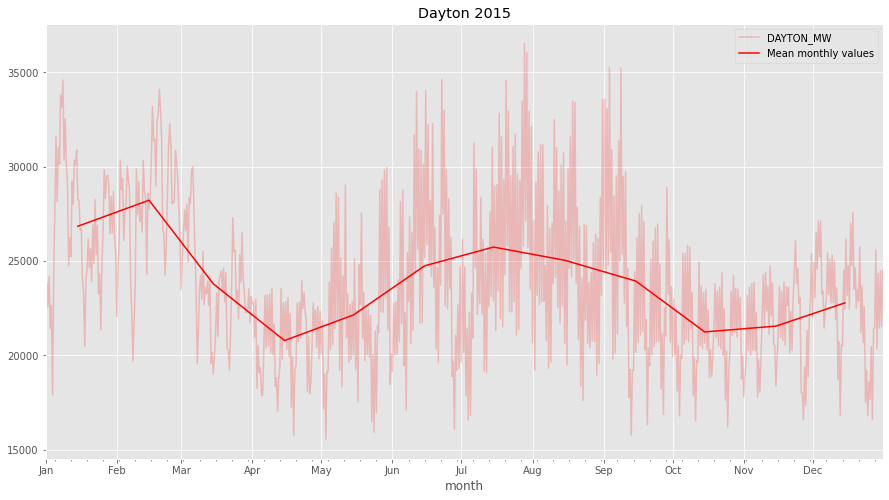

In [183]:
year_2015 = data[data.index.year == 2015]

month_mean_values = []
months = []
xticks = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in (range(1,13)):
    month_mean_values.append(year_2015[(year_2015.index.month == i)]['DAYTON_MW'].mean())
    months.append(datetime.datetime(2015, i, 15))
    xticks.append(datetime.datetime(2015, i, 1)) 

month = pd.DataFrame({'Mean monthly values': month_mean_values, 'month':months })
month = month.set_index('month')

base=year_2015.plot(color='red',alpha=0.20, figsize = (15, 8), title = 'Dayton 2015')
month.plot(color='red', alpha=1.0, ax=base)
plt.xticks(xticks, month_names)

plt.show()

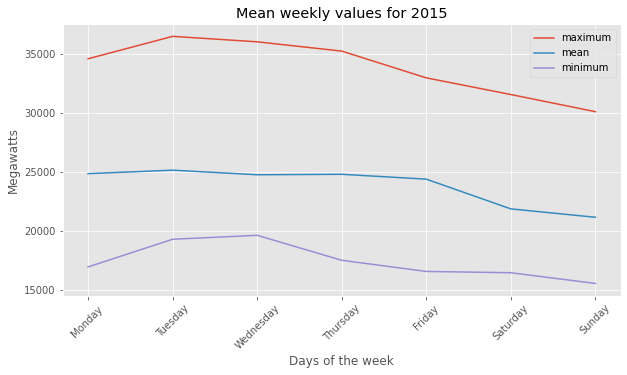

In [184]:
# VALUES BY WEEKDAY

mean_weekday = []
max_weekday = []
min_weekday = []
weekdays = ['Monday ', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(0, 7):
  mean_weekday.append(data[(data.index.year == 2015) & (data.index.weekday == i)].mean())
  max_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].max())
  min_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].min())

plt.figure(figsize = (10, 5))
plt.plot(weekdays, max_weekday, weekdays, mean_weekday, weekdays, min_weekday)

plt.title('Mean weekly values for 2015')
plt.xlabel('Days of the week')
plt.ylabel('Megawatts')
plt.xticks(weekdays, rotation = 45)
plt.legend(['maximum', 'mean', 'minimum'])

plt.show()

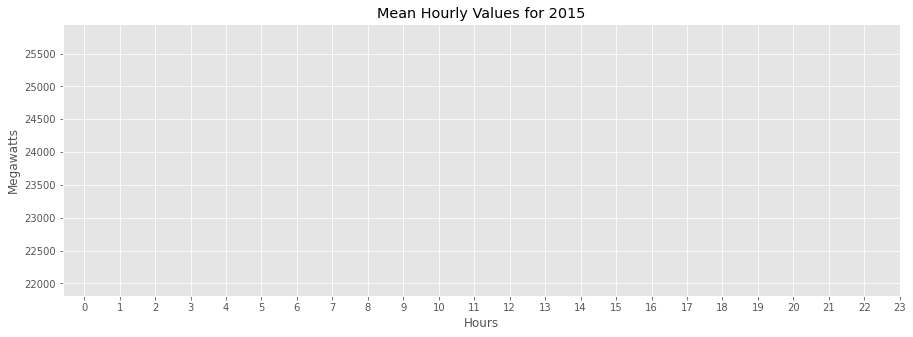

In [185]:
#           MEAN HOURLY VALUES

mean_hourly_values = []
hours = [x for x in range(0, 24)]

for i in range(0, 24):
  mean_hourly_values.append(data[(data.index.year == 2015) & (data.index.hour == i)].mean())

plt.figure(figsize = (15, 5))
plt.plot(hours, mean_hourly_values)

plt.title("Mean Hourly Values for 2015")
plt.xlabel("Hours")
plt.ylabel("Megawatts")
plt.xticks(hours)

plt.show()

Preprocessing

- Normalize the dataset

In [186]:
data = data[data.index.year >= 2008]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

- Splitting the training and test sets

In [187]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

7735 6188 1547


In [188]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [189]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
# https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras

look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

Hyperparameters

In [190]:
n_epochs = 10                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0002   

n_input = 1                       # Scalar input.
n_neurons = 128                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

Create model

In [191]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(trainX.shape[1],look_back)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))         # LSTM.
lstm_model.add(Dense(1))                # Wrapper.

# Define the optimizer and compile.
my_optimizer=Adam(lr=learn_rate)
lstm_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [192]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 40)             9760      
                                                                 
 dropout_18 (Dropout)        (None, 1, 40)             0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 40)             12960     
                                                                 
 dropout_19 (Dropout)        (None, 1, 40)             0         
                                                                 
 lstm_20 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_20 (Dropout)        (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

Train model

In [193]:
%%time
my_summary = lstm_model.fit(trainX, trainY, epochs=n_epochs, batch_size = batch_size)

Epoch 1/10
6168/6168 [==============================] - 46s 6ms/step - loss: 0.0143 - mse: 0.0143
Epoch 2/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 3/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 4/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 5/10
6168/6168 [==============================] - 27s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 6/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0027 - mse: 0.0027
Epoch 7/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0025 - mse: 0.0025
Epoch 8/10
6168/6168 [==============================] - 26s 4ms/step - loss: 0.0023 - mse: 0.0023
Epoch 9/10
6168/6168 [==============================] - 27s 4ms/step - loss: 0.0022 - mse: 0.0022
Epoch 10/10
6168/6168 [==============================] - 25s 4ms/step - loss: 0.0022 - mse: 0.0022
CPU times: user 6mi

In [194]:
#my_model.save('LSTM_model.h5')
#my_model = load_model('LSTM_model.h5')

In [195]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

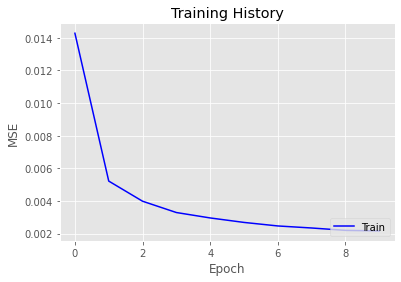

In [196]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

Predict

In [197]:
# make predictions
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [198]:
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
#trainY = scaler.inverse_transform(trainY.reshape(-1,1))
#testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
#testY = scaler.inverse_transform(testY.reshape(-1,1))

In [199]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


Evaluate predictions

In [200]:
trainPred = pd.DataFrame({'Prediction' : trainPredict.reshape(-1)}, index = data.iloc[look_back + 1 : len(trainPredict) + look_back + 1].index)
testPred = pd.DataFrame({'Prediction' : testPredict.reshape(-1)}, index = data.iloc[-len(test)+look_back:].index)

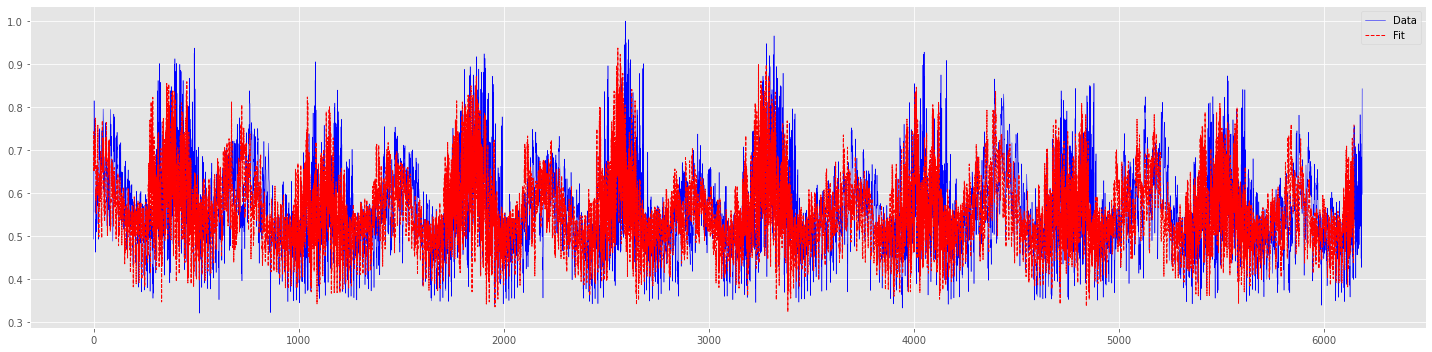

In [201]:
# Compare the training preditiction

plt.figure(figsize = (20, 5))

plt.plot(normalized_data[:len(train)], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(trainPredict[look_back : ], c='r',linewidth=1, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

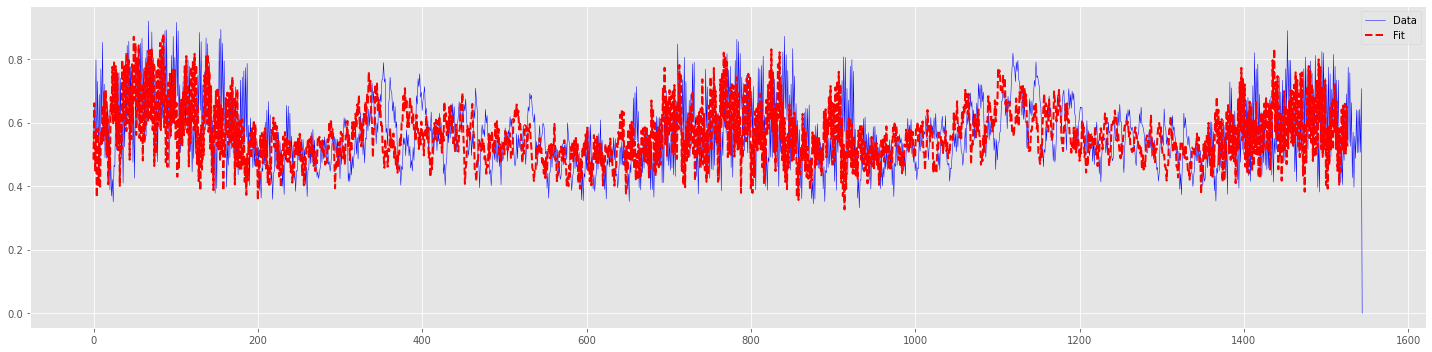

In [202]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(normalized_data[-len(test)+2:], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(testPredict, c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()